### Set-up

#### Load models

In [1]:
from sentence_transformers import SentenceTransformer
from PIL import Image
import requests
from pathlib import Path

# The original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

# The second model is aligned - i.e. it maps to the same vector space as the original model
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

# Read more about the models at:
# https://huggingface.co/sentence-transformers/clip-ViT-B-32
# https://huggingface.co/sentence-transformers/clip-ViT-B-32-multilingual-v1

#### Helper functions

In [2]:
# Helper function for loading an image or URL
def load_image(url_or_path):
    if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
        return Image.open(requests.get(url_or_path, stream=True).raw)
    else:
        return Image.open(url_or_path)

In [3]:
import base64

# Helper function to convert a file to base64 representation
def to_base64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

In [4]:
# Helper function for showing images in Jupyter (using Matplotlib)
import matplotlib.pyplot as plt

def show_images(response, src_img=None):
    # Load all 3 images into a list and show them in Jupyter with matplotlib
    images = [load_image(o.properties["file_path"]) for o in response.objects]
    if src_img:
        images = [src_img] + images
    _, axs = plt.subplots(1, len(images), figsize=(20, 10))
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
    return None

#### Load data

In [5]:
# Use local paths for the dataset
# Data from TMDB; gathered through their API. (https://www.themoviedb.org/)
poster_img_dir = Path("data/posters")
poster_img_paths = [str(p) for p in poster_img_dir.glob("*.jpg")]

In [6]:
print(len(poster_img_paths))

1639


### Connect to Weaviate

In [7]:
import weaviate
import weaviate.classes as wvc
from weaviate.util import generate_uuid5

client = weaviate.connect_to_embedded(version="1.23.6")  # Downloads Weaviate and directly spins up an instance
# Could also be a local instance or a remote instance
# client = weaviate.connect_to_local(port=8070, grpc_port=50041)  # Local instance (e.g. Kubernetes or Docker)
# client = weaviate.connect_to_wcs()  # Weaviate Cloud Service (SaaS)

Started /Users/jphwang/.cache/weaviate-embedded: process ID 58885


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-01-30T15:44:25Z"}

{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-01-30T15:44:25Z"}

{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-01-30T15:44:25Z"}

{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2024-01-30T15:44:25Z"}

{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2024-01-30T15:44:25Z"}

{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time"

In [8]:
coll_name = "MultiModal"

### Create a collection

In [9]:
# Create the collection
client.collections.create(
    name=coll_name,
    vectorizer_config=wvc.config.Configure.Vectorizer.none(),  
    generative_config=wvc.config.Configure.Generative.openai(),
    properties=[
        wvc.config.Property(
            name="file_path",
            data_type=wvc.config.DataType.TEXT
        ),
        wvc.config.Property(
            name="img_source",
            data_type=wvc.config.DataType.TEXT
        ),
        wvc.config.Property(
            name="image",
            data_type=wvc.config.DataType.BLOB
        ),
    ]
)

{"level":"info","msg":"Created shard multimodal_ARqioJgwbYuT in 1.906875ms","time":"2024-01-30T15:44:26Z"}

{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-01-30T15:44:26Z","took":53833}


### Add data to the collection

In [10]:
import time

# Get the collection
mm_coll = client.collections.get(coll_name)

# Add the objects using a batch process
counter = 0
start_time = time.time()
with mm_coll.batch.dynamic() as batch:
    for img_set in [
        (poster_img_paths, "TMDB"),
    ]:
        for img_path in img_set[0][:100]:
            # Get the vector from the image model
            vector = img_model.encode([load_image(img_path)])[0].tolist()
            img_b64 = to_base64(img_path)

            # Add the object to the batch
            batch.add_object(
                properties={
                    "file_path": img_path,
                    "image": img_b64,
                    "img_source": img_set[1]
                },
                vector=vector,  # Specify the vector
                uuid=generate_uuid5(img_path)
            )
            counter += 1
            if counter % 500 == 0:
                print(f"Added {counter} objects. {time.time() - start_time} seconds for last 500 objects.")
                start_time = time.time()

{"action":"lsm_recover_from_active_wal","class":"Question","index":"question","level":"warning","msg":"active write-ahead-log found. Did weaviate crash prior to this? Trying to recover...","path":"/Users/jphwang/.local/share/weaviate/question/UzLPXGzS2W3v/lsm/objects/segment-1706628545602084000.wal","shard":"UzLPXGzS2W3v","time":"2024-01-30T15:44:26Z"}

{"action":"lsm_recover_from_active_wal_success","class":"Question","index":"question","level":"info","msg":"successfully recovered from write-ahead-log","path":"/Users/jphwang/.local/share/weaviate/question/UzLPXGzS2W3v/lsm/objects/segment-1706628545602084000.wal","shard":"UzLPXGzS2W3v","time":"2024-01-30T15:44:26Z"}

{"action":"lsm_recover_from_active_wal","class":"Question","index":"question","level":"warning","msg":"active write-ahead-log found. Did weaviate crash prior to this? Trying to recover...","path":"/Users/jphwang/.local/share/weaviate/question/UzLPXGzS2W3v/lsm/property__id/segment-1706628545603170000.wal","shard":"UzLPXGzS2

## Queries

### Get the collection object

In [11]:
mm_coll = client.collections.get(coll_name)

### Search objects by text

Showing movie posters closest to query: 'man with suitcase'


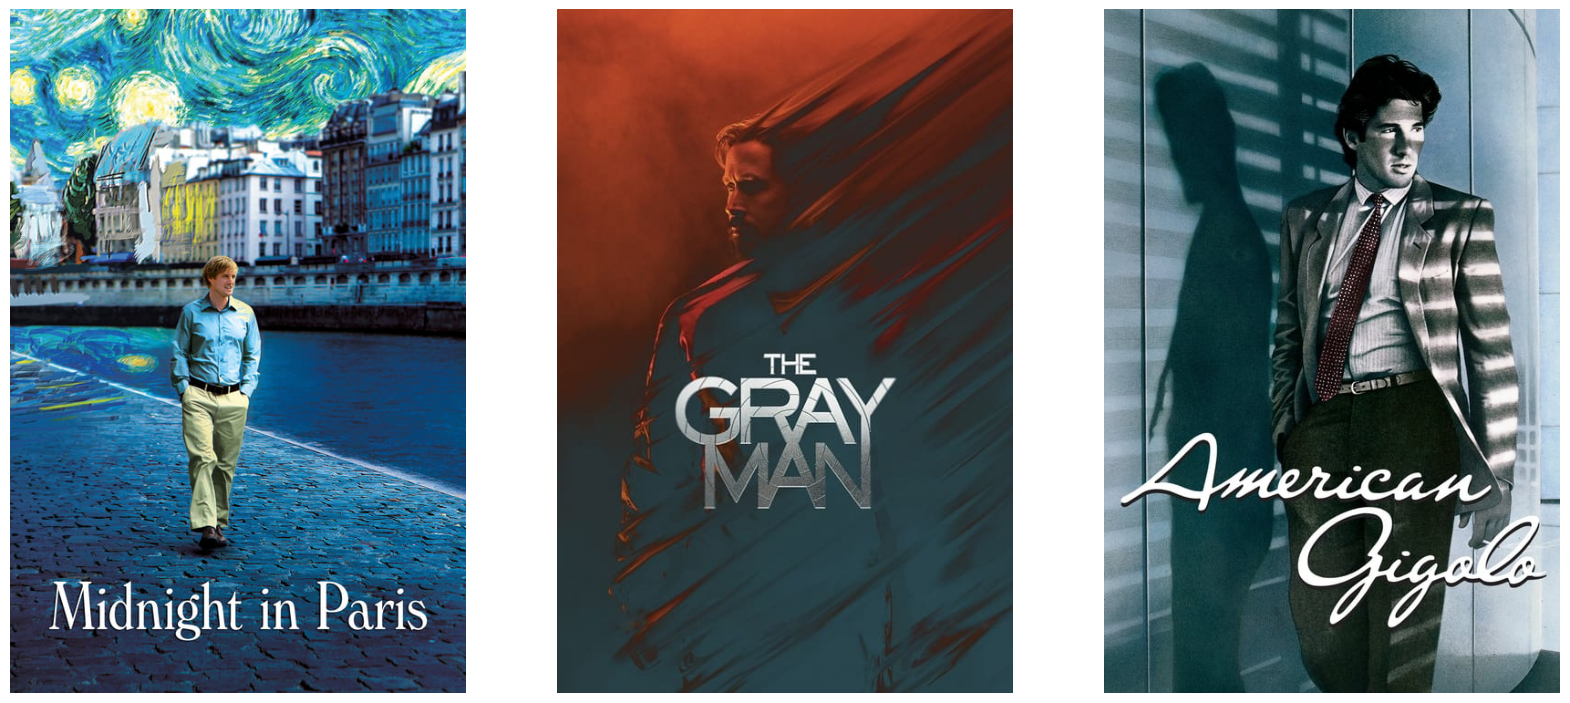

In [12]:
query = "man with suitcase"
text_vec = text_model.encode([query])[0].tolist()

response = mm_coll.query.near_vector(
    near_vector=text_vec,
    return_properties=["image", "file_path"],
    filters=wvc.query.Filter.by_property("img_source").equal("TMDB"),
    limit=3
)

print(f"Showing movie posters closest to query: '{query}'")
show_images(response)


### Search objects by image

Showing movie posters closest to the first (left-side) image


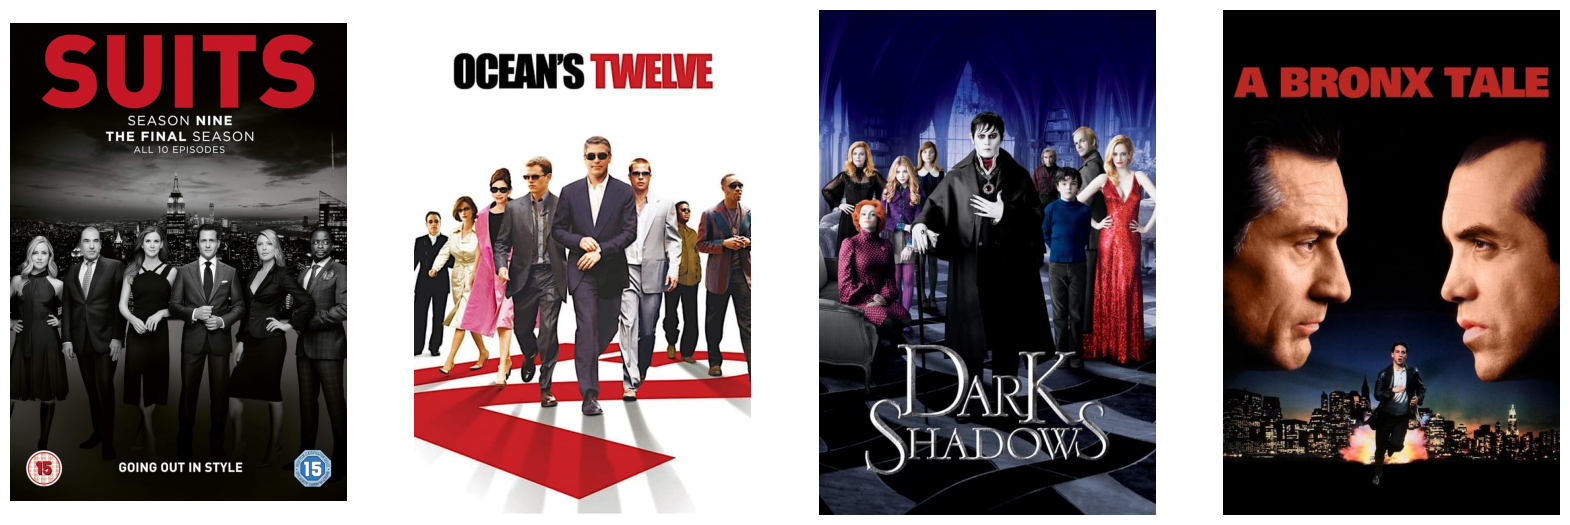

In [13]:
src_img = load_image("data/query/tv_suits_10.jpg")
img_vec = img_model.encode([src_img])[0].tolist()

response = mm_coll.query.near_vector(
    near_vector=img_vec,
    return_properties=["image", "file_path"],
    filters=wvc.query.Filter.by_property("img_source").equal("TMDB"),
    limit=3
)

print(f"Showing movie posters closest to the first (left-side) image")
show_images(response, src_img)

Showing movie posters closest to query: 'red cars'


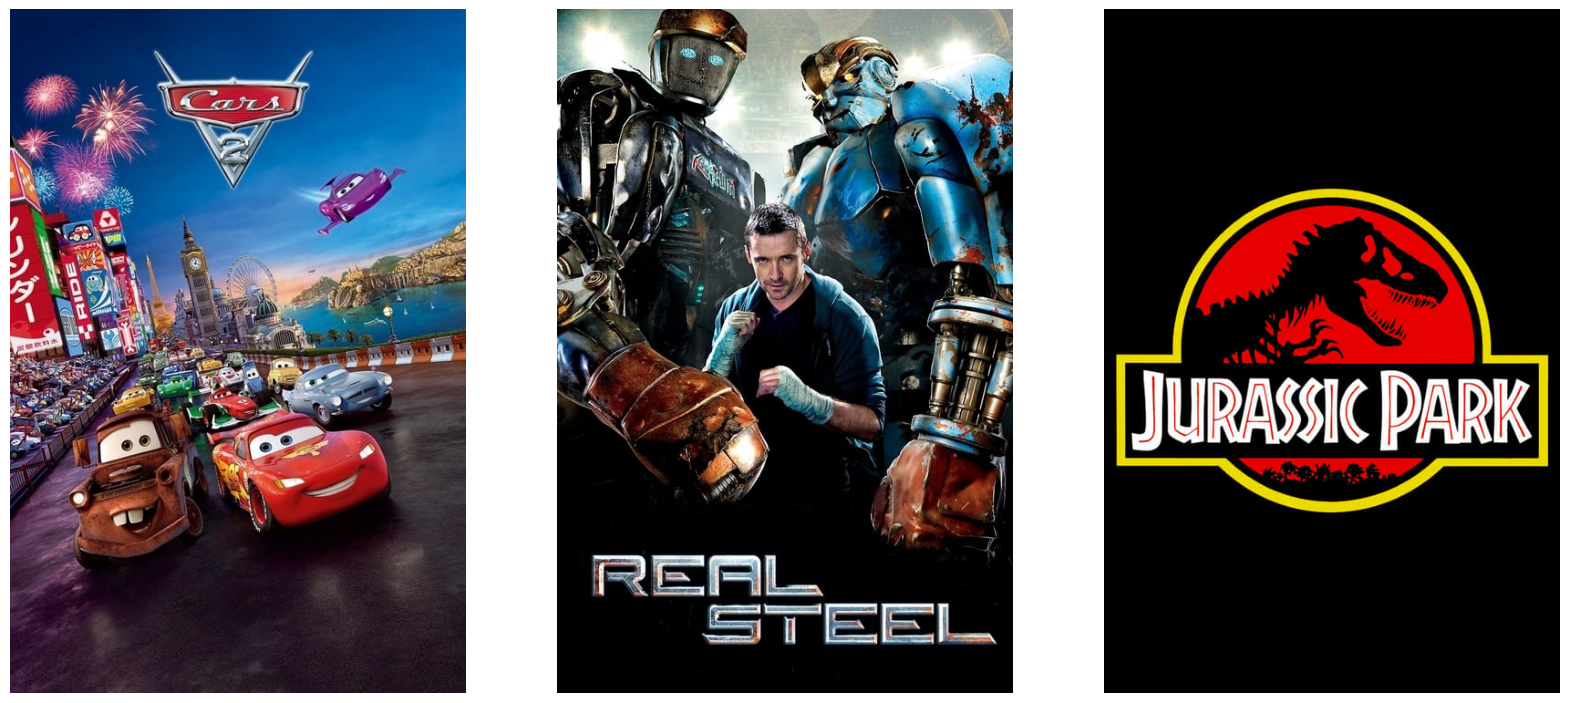

In [14]:
query = "red cars"
text_vec = text_model.encode([query])[0].tolist()

response = mm_coll.query.near_vector(
    near_vector=text_vec,
    return_properties=["image", "file_path"],
    filters=wvc.query.Filter.by_property("img_source").equal("TMDB"),
    limit=3
)

print(f"Showing movie posters closest to query: '{query}'")
show_images(response)